# TP2: Interação e Concorrência

Francisco Oliveira a82066

Nuno Morais a77368

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
from qiskit.providers.ibmq import least_busy
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt

In [2]:
backend_statevector = Aer.get_backend('statevector_simulator')
backend_qasm_sim = Aer.get_backend("qasm_simulator")

In [3]:
backend_statevector

StatevectorSimulator('statevector_simulator')

## Descrição do Trabalho
Cada grupo de estudantes tem um número atribuído N e é pretendido utilizar um algoritmo quântico para encontrar o número s respetivo. O nosso grupo de trabalho é o 4 e usaremos o algoritmo de Grover para encontrar o s numa lista de 8 possíveis. Nesta exemplificação como é numa lista de 8 possíveis foi decidido aplicar 4%8 = 4 então pretendemos encontrar a representação binária de 4 que é 100.

In [4]:
wb = bin(4)[2:]
print(wb)

100


In [5]:
# 4 = {100} logo são necessários 3 qubits

n = 3
print('number of qubits: ', n)

number of qubits:  3


## 1. Simulação do vetor de estado 

Definimos a função simulate_circuit pois iriamos ter de correr os comandos nela contida várias vezes para simular o circuito e então decidimos criar uma função com esses mesmos comandos

In [6]:
def simulate_circuit(qc):

 global backend_statevector

 result = execute(qc, backend_statevector).result()
 statevector = result.get_statevector(qc)

 return statevector

Na função select_w aplicamos o gate x ao circuito para obtermos o estado pretendido.
A função phase_oracle serve para criar o oráculo.
Tendo em conta que apenas estamos a trabalhar com 3 qubits não foi necessário usar a função decompose utilizada nas aulas e apenas aplicamos o Toffoli gate.

In [7]:
def select_w(circuit, qr_x):
 circuit.x(qr_x[0])
 circuit.x(qr_x[1])

def phase_oracle(circuit, qr_x):
 select_w(circuit, qr_x)

 circuit.h(2)
 circuit.ccx(0, 1, 2)
 circuit.h(2)
    
 select_w(circuit, qr_x)

A função diffuser é utilizada para aplicar o difusor que para além de fazer flip do input desejado aumenta a sua amplitude.

In [8]:
def diffuser(circuit, qr_x):
 circuit.h(qr_x)
 circuit.x(qr_x)

 circuit.h(2)
 circuit.ccx(0, 1, 2)
 circuit.h(2) 

 circuit.x(qr_x)
 circuit.h(qr_x)

### Inicialização 

In [9]:
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.h(1)
qc.h(2)
qc_sim = simulate_circuit(qc)

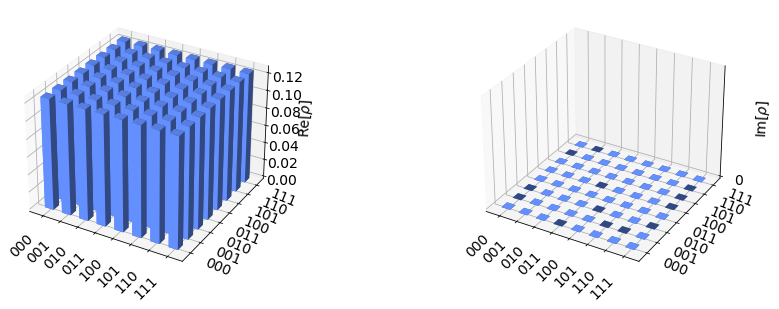

In [10]:
plot_state_city(qc_sim)

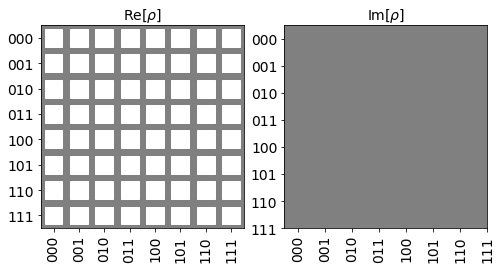

In [11]:
plot_state_hinton(qc_sim)

Nesta fase de inicialização podemos observar , como previsto , que todos os estados, entre |000> e |111> têm a mesma probabilidade.

### Aplicação do oráculo 

In [12]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
# Aplicação do Oráculo
phase_oracle(qc, qr)
qc_sim = simulate_circuit(qc)

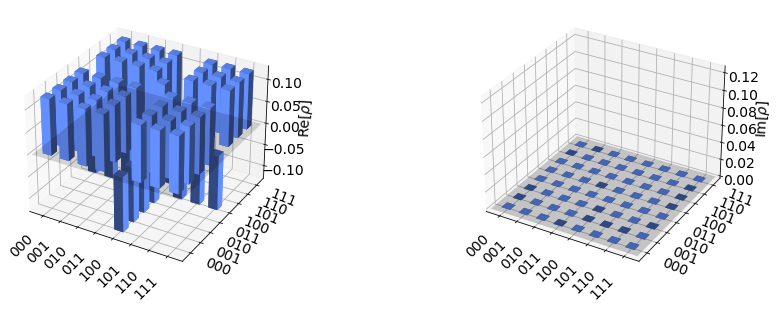

In [13]:
plot_state_city(qc_sim)

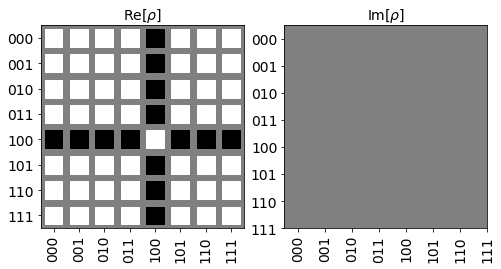

In [14]:
plot_state_hinton(qc_sim)

Após a aplicação do oráculo podemos então observar que os valores de |100> foram alterados.

### Aplicação do difusor

In [15]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
# Aplicação do Oráculo
phase_oracle(qc, qr)
# Aplicação do difusor
diffuser(qc, qr)
qc_sim = simulate_circuit(qc)

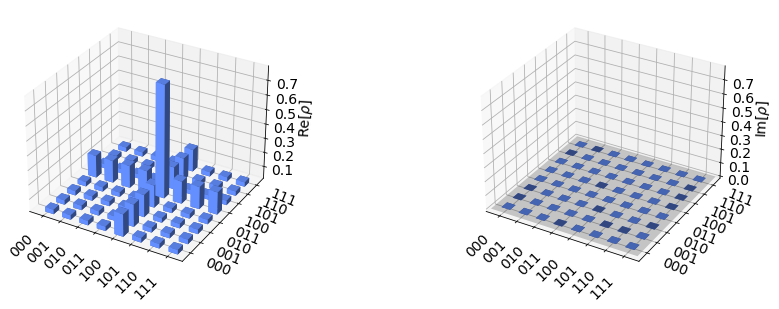

In [16]:
plot_state_city(qc_sim)

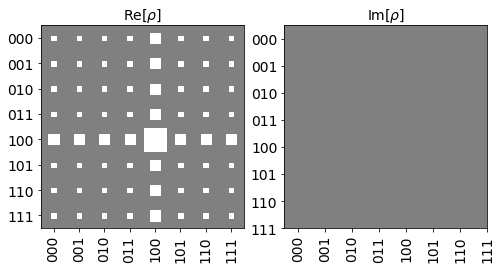

In [17]:
plot_state_hinton(qc_sim)

Como podemos ver, após a aplicação do difusor, a probabilidade dos estados exceto o estado $|100>$ baixou de forma considerável tal como era pretendido ao aplicar o difusor.

### Medição dos qubits

Os passos anteriores têm de ser repetidos aproximadamente $\sqrt{N}$ vezes para obter uma medição optimizada.

In [18]:
import math
x = math.floor(math.sqrt(2**3))
#x = round(math.sqrt(2**3))
x

2

In [19]:
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
qc = QuantumCircuit(qr, cr)
# Inicialização
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
for t in range(x):
 # Aplicação do Oráculo
 phase_oracle(qc, qr)
 # Aplicação do difusor
 diffuser(qc, qr)
qc.barrier()
qc.measure(qr, cr)
qc_sim = simulate_circuit(qc)

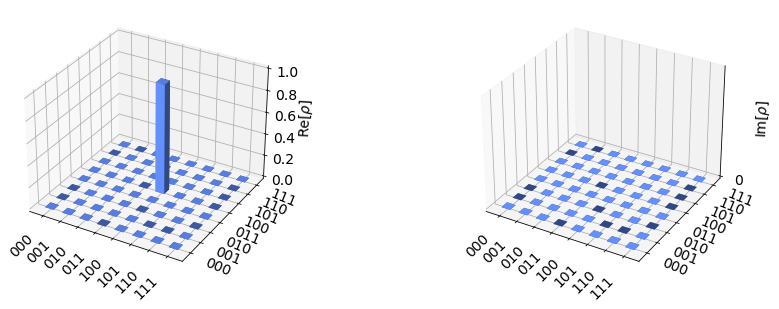

In [20]:
plot_state_city(qc_sim)

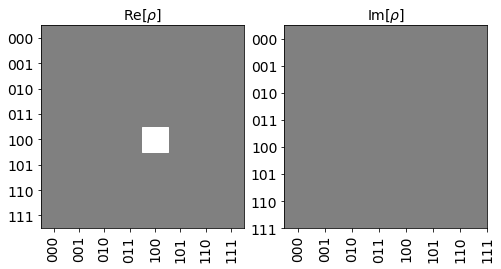

In [21]:
plot_state_hinton(qc_sim)

Após as $x$ aplicações do oráculo e do difusor obtemos os resultados acima.

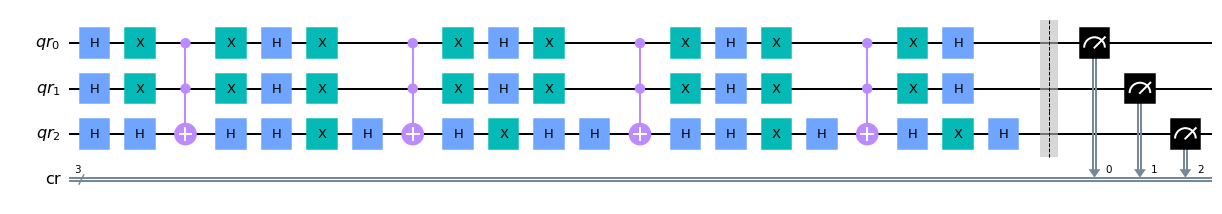

In [22]:
qc.draw(output='mpl')

Simulação sem ruído:
    


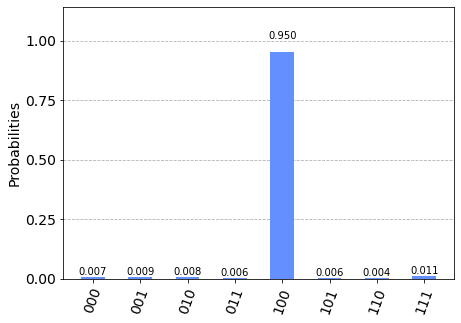

In [23]:
job = execute(qc, backend_qasm_sim, shots=1024)
result = job.result()
counts_sim = result.get_counts()
plot_histogram(counts_sim)

A partir deste gráfico podemos verificar que a probabilidade do estado $|100>$ é maior do que a probabilidade de todos os outros estados.

## 2. Simulação com ruído

De seguida usamos o Aer para prever qual a melhor optimização com ruído.

In [24]:
from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [25]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [26]:
coupling_map = backend_device.configuration().coupling_map
noise_model = NoiseModel.from_backend(backend_device)
basis_gates = backend_device.configuration().basis_gates

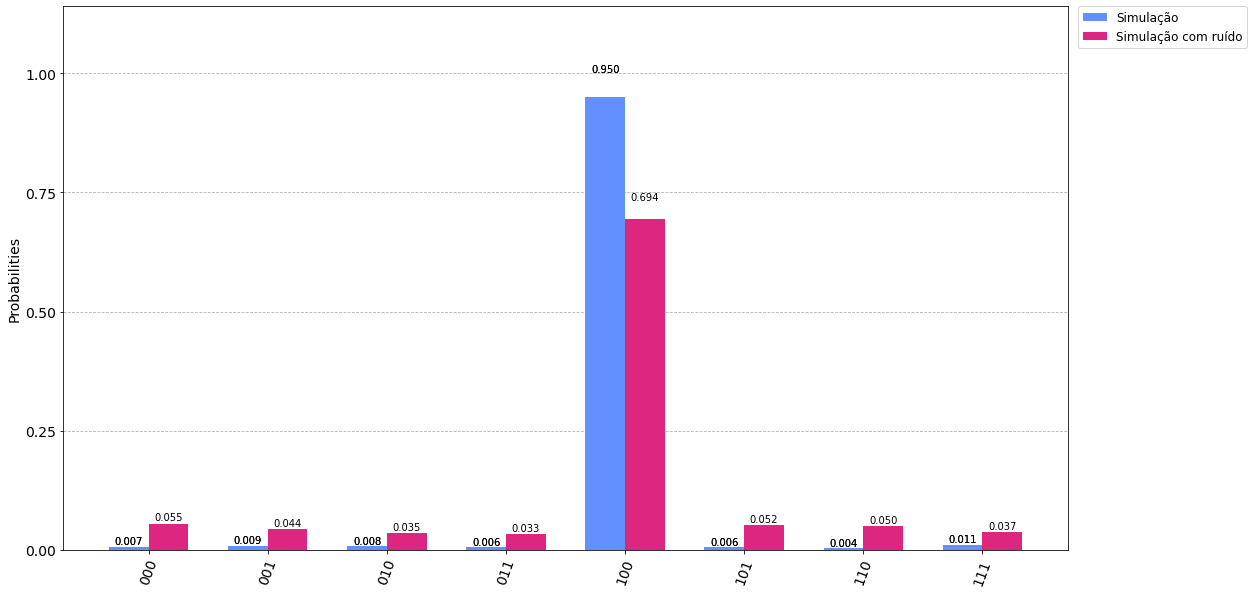

In [27]:
qc_opt0 = transpile(qc, backend=backend_device, optimization_level=0)


result_noise = execute(qc_opt0, backend_qasm_sim,shots = 1024*100, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise0 = result_noise.get_counts(qc_opt0)

plot_histogram([counts_sim, counts_noise0], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

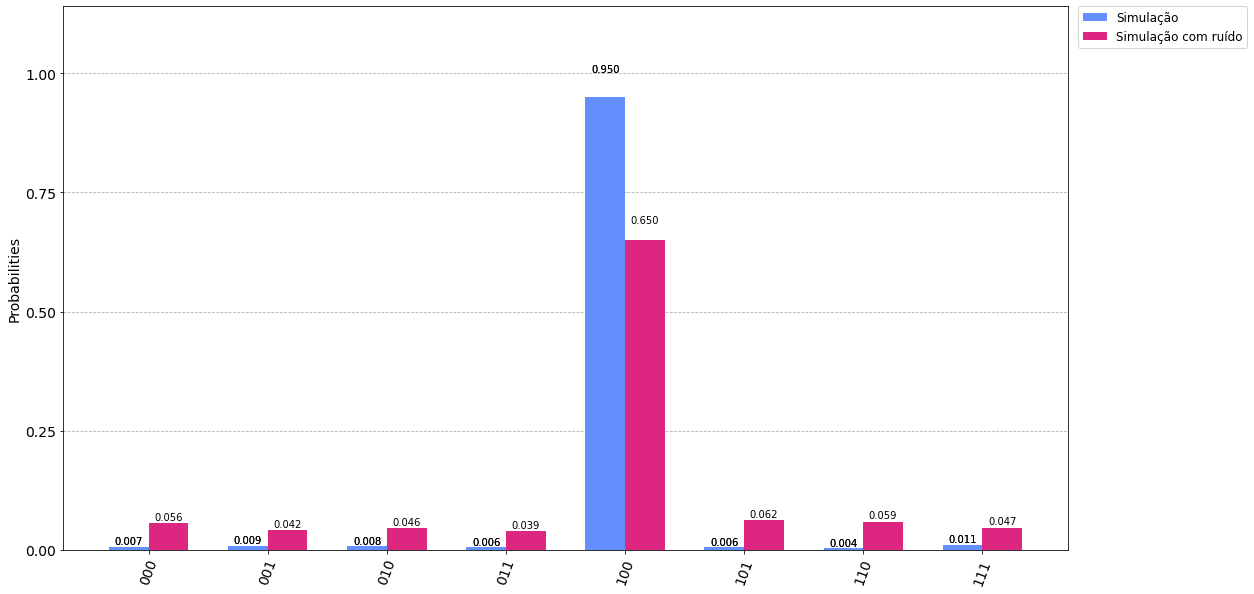

In [28]:
qc_opt1 = transpile(qc, backend=backend_device, optimization_level=1)


result_noise = execute(qc_opt1, backend_qasm_sim,shots = 1024*100, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise1 = result_noise.get_counts(qc_opt1)

plot_histogram([counts_sim, counts_noise1], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

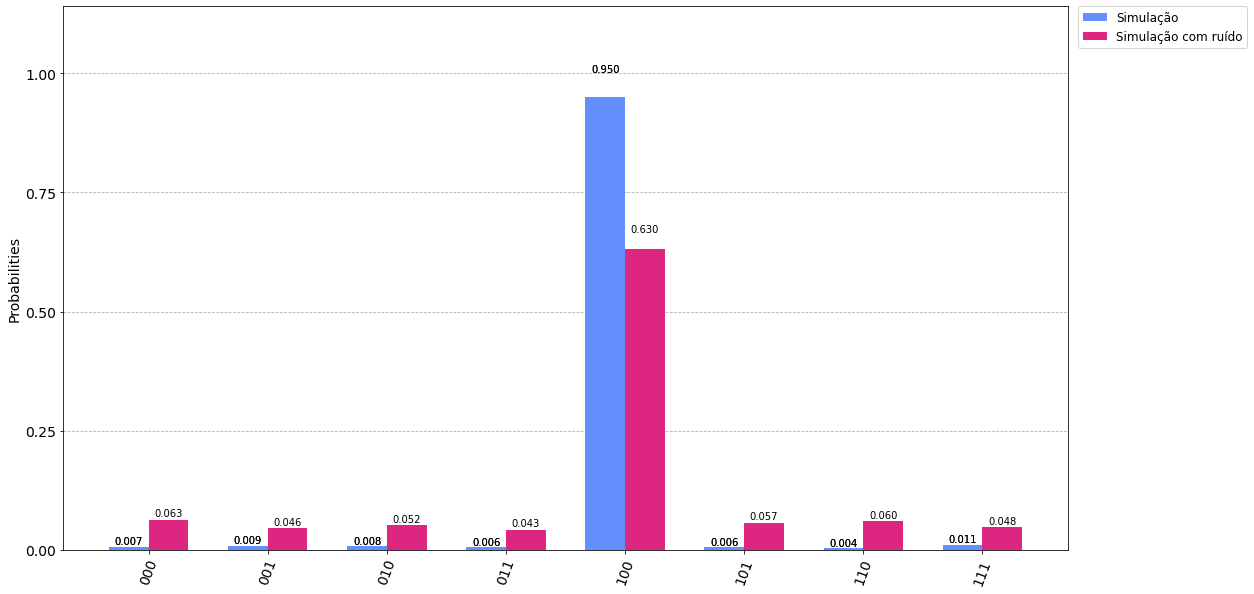

In [29]:
qc_opt2 = transpile(qc, backend=backend_device, optimization_level=2)


result_noise = execute(qc_opt2, backend_qasm_sim,shots = 1024*100, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise2 = result_noise.get_counts(qc_opt2)

plot_histogram([counts_sim, counts_noise2], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

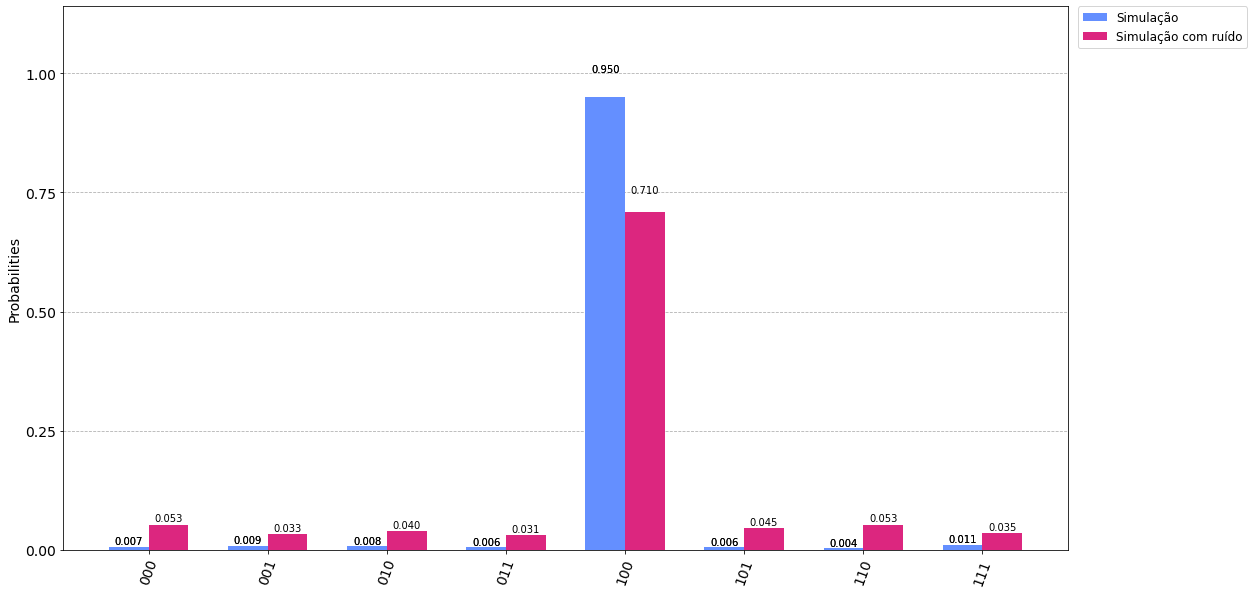

In [30]:
qc_opt3 = transpile(qc, backend=backend_device, optimization_level=3)


result_noise = execute(qc_opt3, backend_qasm_sim,shots = 1024*100, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise3 = result_noise.get_counts(qc_opt3)

plot_histogram([counts_sim, counts_noise3], legend=[ "Simulação", "Simulação com ruído" ], figsize=(18, 10))

Depois de utilizarmos os diferentes níveis de optimização várias vezes, concluímos que o melhor nível de optimização é o 3, pois é nível que mais consistentemente obteve uma probabilidade mais próxima da probabilidade obtida ao fazer a simulação sem ruído.

In [31]:
qc_opt = transpile(qc, backend=backend_device, optimization_level=3)

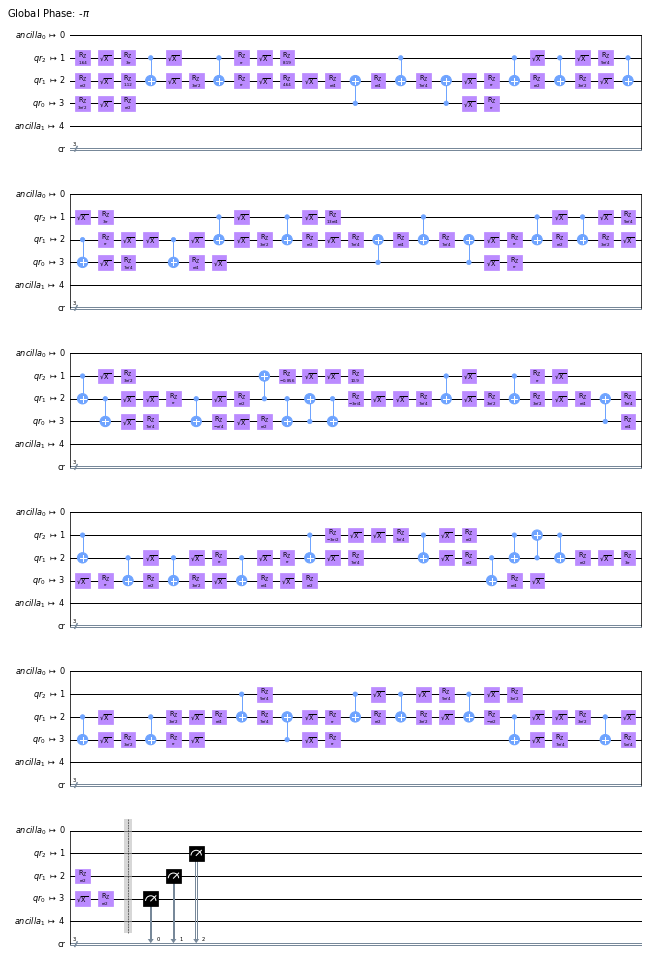

In [32]:
qc_opt.draw(output='mpl', scale=0.5)

## 3. Simulação num computador quântico <a id='run'></a>

Neste ponto do trabalho utilizamos um computador quântico para correr a nossa simulação.

In [33]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

In [34]:
from qiskit.tools.monitor import backend_overview, backend_monitor

#backend_overview()

Após alguns testes reparamos que o ibmq_santiago obteve os resultados mais altos e por esta mesma razão o escolhemos.

In [35]:
backend_device = provider.get_backend('ibmq_santiago')
print("Running on: ", backend_device)

Running on:  ibmq_santiago


In [36]:
#backend_monitor(backend_device)

In [37]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [38]:
job_r = execute(qc_opt, backend_device, shots=1024)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bc00791eb0242a4fceee0b


In [39]:
job = backend_device.retrieve_job('60bc00791eb0242a4fceee0b')
job_result = job.result()

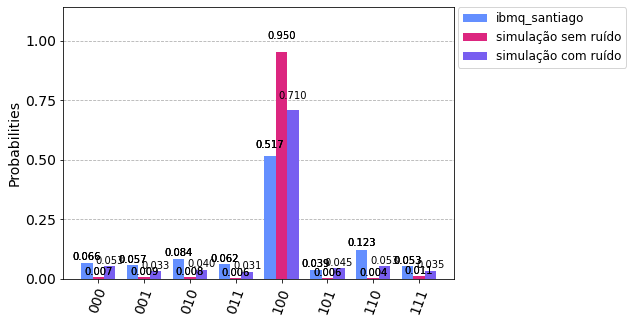

In [40]:
counts_job = job_result.get_counts()
plot_histogram([counts_job, counts_sim, counts_noise3], legend=['ibmq_santiago', 'simulação sem ruído', 'simulação com ruído'])

## 4. Mitigação de erros com Ignis

De seguida, utilizamos o Ignis para mitigar o erro de forma a obtermos uma probabilidade mais próxima da probabilidade obtida na simulação sem ruído.

Começamos por fazer a calibração.

### Calibração

Na calibração começamos por gerar uma lista com os vários circuitos de calibração de medição em que cada circuito cria um estado base.
Como utilizamos 3 qubits, precisamos de $2^3 = 8$ circuitos de calibração.

In [41]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                CompleteMeasFitter, TensoredMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [42]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

### Computação da matriz de calibração

Caso não tivesse existido ruído, a matriz de calibração seria a matriz identidade o que não será o caso.

In [43]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=1024)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bc00a643987e27a8f108f3


In [44]:
job_get=backend_device.retrieve_job("60bc00a643987e27a8f108f3")

cal_results = job_get.result()

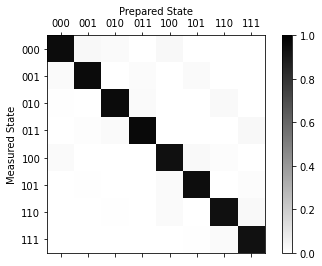

In [45]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

In [46]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.944580


### Aplicação da calibração

A nossa raw data será o `job_result` e vamos aplicar o filter baseado na matriz de calibração para obter os mitigated_counts que são as probabilidades obtidas através da mitigação.

In [47]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(job_result)
mitigated_counts = mitigated_results.get_counts()

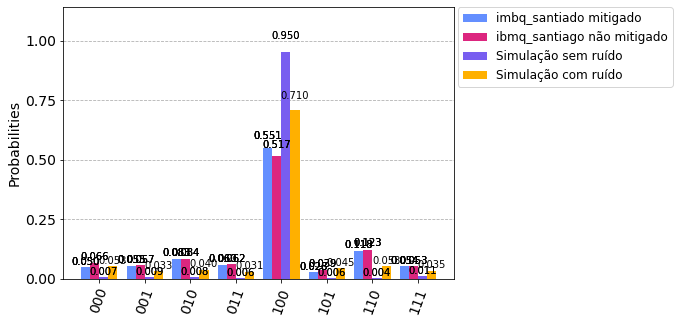

In [48]:
plot_histogram([mitigated_counts, counts_job, counts_sim, counts_noise3], legend=['imbq_santiado mitigado', 'ibmq_santiago não mitigado', 'Simulação sem ruído', 'Simulação com ruído'])

Podemos então concluir que a solução do valor mitigado , embora mais próxima , fica ainda um pouco longe do valor da simulação com ruído.